# <center>**IMPORT LIBRARY**</center>


In [1]:
import numpy as np  # Untuk operasi vektor dan matriks
import pandas as pd  # Untuk operasi data frame
import matplotlib.dates as mdates  # Untuk mengubah format tanggal
from statsmodels.tsa.arima.model import ARIMA  # Untuk membuat model ARIMA
from statsmodels.tools.eval_measures import rmse  # Untuk menghitung nilai RMSE
from pmdarima import auto_arima  # Untuk menentukan parameter model ARIMA
import matplotlib.pyplot as plt  # Untuk membuat plot
from tkinter import *
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

# <center>**GATHERING DATA**</center>


In [2]:
df = pd.read_excel(
    "Tabel Harga Berdasarkan Daerah (7).xlsx", header=None
)  # Membaca file excel


# Transpose data frame untuk mempermudah proses analisis
df = df.T

df

,0,1,2,3,4,5,6,7
0,No,I,1,2,3,4,5,6
1,Komoditas (Rp),Beras,Beras Kualitas Bawah I,Beras Kualitas Bawah II,Beras Kualitas Medium I,Beras Kualitas Medium II,Beras Kualitas Super I,Beras Kualitas Super II
2,02/ 04/ 2018,"11,050",-,-,"9,300","8,900","15,000","11,000"
3,09/ 04/ 2018,"11,050",-,-,"9,300","8,900","15,000","11,000"
4,16/ 04/ 2018,"11,050",-,-,"9,300","8,900","15,000","11,000"
...,...,...,...,...,...,...,...,...
294,06/ 11/ 2023,"12,450","11,850","11,200","12,550","12,650","13,500","13,000"
295,13/ 11/ 2023,"12,450","11,850","11,200","12,550","12,650","13,500","13,000"
296,20/ 11/ 2023,"12,450","11,700","11,200","12,550","12,650","13,500","13,000"
297,27/ 11/ 2023,"12,500","11,750","11,350","12,600","12,600","13,350","12,950"


# <center>**DATA PREPARATION & CLEANING**</center>


In [4]:
# Mengubah nama kolom
df1 = df.rename(
    {
        0: "Tanggal",
        1: "Beras",
        2: "Beras Kualitas Bawah I",
        3: "Beras Kualitas Bawah II",
        4: "Beras Kualitas Medium I",
        5: "Beras Kualitas Medium II",
        6: "Beras Kualitas Super I",
        7: "Beras Kualitas Super II",
    },
    axis=1,
)

# Menghapus baris pertama dan kedua
df1 = df1.drop(df1.index[[0, 1]])

y = df1.copy()  # Copy data frame ke variabel baru "y"

y.replace("-", np.nan, inplace=True)  # Mengganti data '-' dengan NaN
y = y.dropna()  # Menghapus data NaN


y = y.applymap(
    lambda x: pd.to_numeric(str(x).replace(",", ""), errors="ignore")
)  # Mengubah tipe data HARGA BERAS menjadi numerik

y["Tanggal"] = pd.to_datetime(
    y["Tanggal"], format='mixed'
)  # Mengubah tipe data 'Tanggal' menjadi datetime
y.set_index("Tanggal", inplace=True)  # Mengubah kolom 'Tanggal' menjadi index
y = y[y.index >= "2018-11-01"]  # Mengambil data dari tanggal 1 November 2018
y

,Beras,Beras Kualitas Bawah I,Beras Kualitas Bawah II,Beras Kualitas Medium I,Beras Kualitas Medium II,Beras Kualitas Super I,Beras Kualitas Super II
Tanggal,,,,,,,
2018-12-11,9500,8950,8600,9350,9200,10200,9550
2018-11-19,9500,8950,8600,9300,9200,10200,9550
2018-11-26,9750,9100,9100,9600,9600,10300,9650
2018-12-17,9750,9100,9100,9600,9600,10300,9650
2018-12-24,9750,9150,9100,9700,9600,10350,9700
...,...,...,...,...,...,...,...
2023-06-11,12450,11850,11200,12550,12650,13500,13000
2023-11-13,12450,11850,11200,12550,12650,13500,13000
2023-11-20,12450,11700,11200,12550,12650,13500,13000


# <center>**DATA NORMALIZATION & TRANSFORMATION**</center>


In [5]:
# Mengambil data rata-rata harga setiap tipe beras per bulan
beras = y["Beras"].resample("MS").mean()
beras_B1 = y["Beras Kualitas Bawah I"].resample("MS").mean()
beras_B2 = y["Beras Kualitas Bawah II"].resample("MS").mean()
beras_M1 = y["Beras Kualitas Medium I"].resample("MS").mean()
beras_M2 = y["Beras Kualitas Medium II"].resample("MS").mean()
beras_S1 = y["Beras Kualitas Super I"].resample("MS").mean()
beras_S2 = y["Beras Kualitas Super II"].resample("MS").mean()
y = y.fillna(y.bfill())  # Mengisi data kosong dengan data sebelumnya

# <center>**DATA PLOTTING**</center>


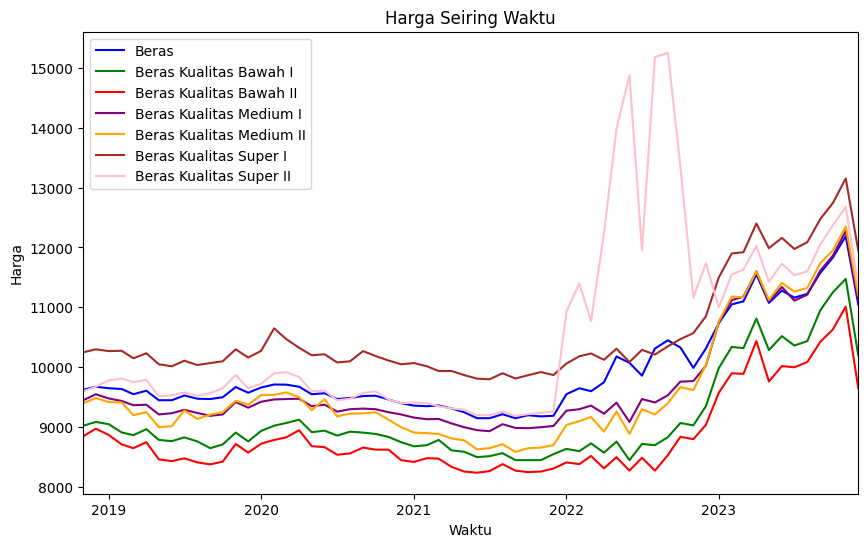

In [6]:
plt.figure(figsize=(10, 6))  # Ukuran plot

plt.plot(beras.index, beras, label="Beras", color="blue")
plt.plot(beras_B1.index, beras_B1, label="Beras Kualitas Bawah I", color="green")
plt.plot(beras_B2.index, beras_B2, label="Beras Kualitas Bawah II", color="red")
plt.plot(beras_M1.index, beras_M1, label="Beras Kualitas Medium I", color="purple")
plt.plot(beras_M2.index, beras_M2, label="Beras Kualitas Medium II", color="orange")
plt.plot(beras_S1.index, beras_S1, label="Beras Kualitas Super I", color="brown")
plt.plot(beras_S2.index, beras_S2, label="Beras Kualitas Super II", color="pink")

plt.xlabel("Waktu")  # Label sumbu x
plt.ylabel("Harga")  # Label sumbu y
plt.title("Harga Seiring Waktu")  # Judul plot
plt.legend()  # Menampilkan legenda

plt.xlim(
    [mdates.date2num(pd.to_datetime("2018-11-01")), max(mdates.date2num(beras.index))]
)  # Batas sumbu x

plt.show()  # Menampilkan plot

# <center>**make a model**</center>


In [354]:
auto_arima_model = auto_arima(beras, m=7, trace=True)

# Mendapatkan nilai order dan seasonal_order dari auto_arima
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Membuat model ARIMA manual dengan nilai yang diperoleh dari auto_arima
model = ARIMA(beras, order=order, seasonal_order=seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=740.316, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=744.480, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=744.264, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=743.837, Time=0.05 sec
 ARIMA(2,1,2)(0,1,1)[7]             : AIC=739.664, Time=0.25 sec
 ARIMA(2,1,2)(0,1,0)[7]             : AIC=737.067, Time=0.11 sec
 ARIMA(2,1,2)(1,1,0)[7]             : AIC=737.851, Time=0.26 sec
 ARIMA(1,1,2)(0,1,0)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(2,1,1)(0,1,0)[7]             : AIC=747.807, Time=0.06 sec
 ARIMA(3,1,2)(0,1,0)[7]             : AIC=738.167, Time=0.13 sec
 ARIMA(2,1,3)(0,1,0)[7]             : AIC=741.563, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,3)(0,1,0)[7]             : AIC=748.054, Time=0.07 sec
 ARIMA(3,1,1)(0,1,0)[7]             : AIC=746.876, Time=0.06 sec
 ARIMA(3,1,3)(0,1,0)[7]             : AIC=739.104, Time

(0, 1, 0, 7)

# <center>**SPLIT TRAIN & TEST DATA, FIT MODEL, PREDICT DATA**</center>


c:\Users\User ID\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User ID\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


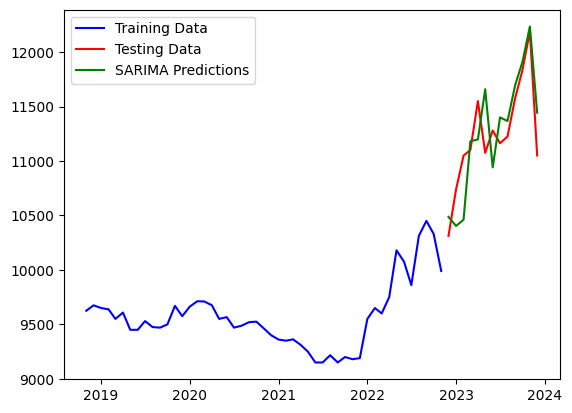

In [345]:
n = int(len(beras)*0.8)  # Menampilkan jumlah data yang di train 80%
train_df = beras.iloc[:n]  # Mengambil data training
test_df = beras.iloc[n:]  # Mengambil data testing

result = model.fit()  # Melatih model ARIMA

start = len(train_df)  # Menentukan awal data testing
end = len(train_df) + len(test_df) - 1  # Menentukan akhir data testing
prediction = result.predict(start=start, end=end).rename(
   "SARIMA Predictions"
)  # Memprediksi data testing
start_date = beras.index.min()  # Menentukan tanggal awal data testing

end_date = beras.index.max()  # Menentukan tanggal akhir data testing

pred = result.get_prediction(
   start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False
)  # Memprediksi data testing
pred_ci = pred.conf_int()  # Menghitung interval kepercayaan

# Menampilkan hasil prediksi
plt.plot(train_df.index, train_df, label='Training Data', color='blue')
plt.plot(test_df.index, test_df, label='Testing Data', color='red')
plt.plot(test_df.index, prediction, label='SARIMA Predictions', color='green')

plt.legend()
plt.show()

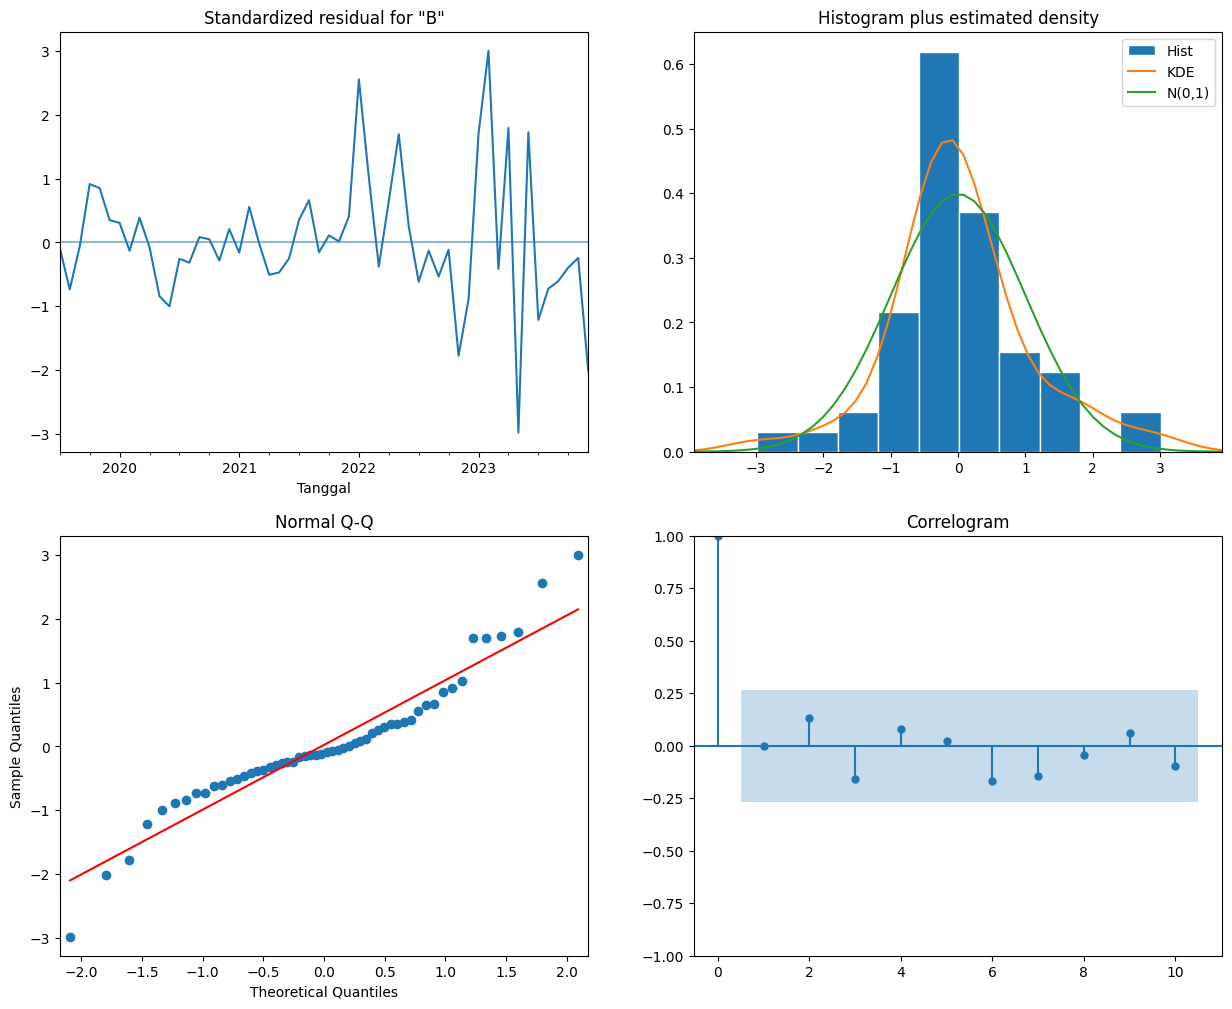

In [346]:
# Plot diagnostik data training
result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [348]:
# standar deviasi data observasi VS nilai RMSE data testing
print('RMSE: ', rmse(test_df, prediction))

RMSE:  319.5551673790058


# <center>**PLOT PREDICTION**</center>


c:\Users\User ID\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


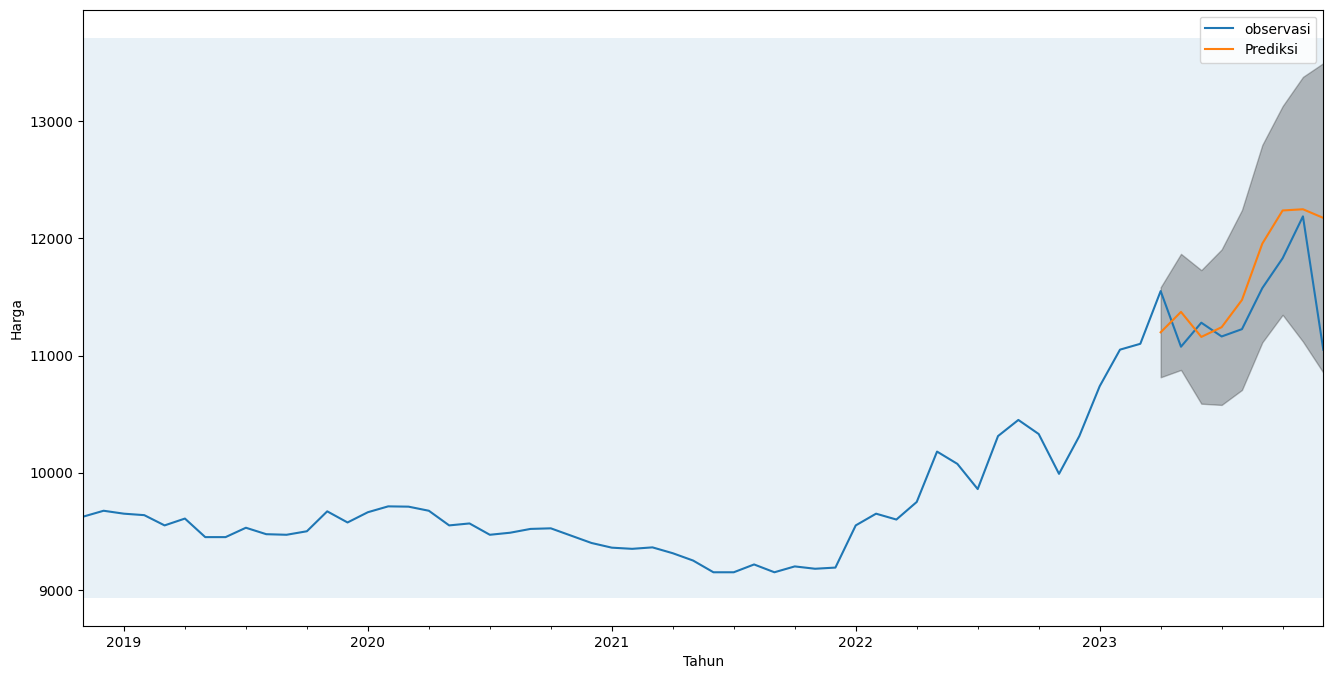

In [349]:
# Prediksi pada test data
pred_dynamic = result.get_prediction(
    start=pd.to_datetime("2023-04-01"), dynamic=True, full_results=True
)  # Memprediksi data testing
pred_dynamic_ci = pred_dynamic.conf_int()  # Menghitung interval kepercayaan
ax = beras.plot(label="observasi", figsize=(16, 8))  # Plot data observasi
pred_dynamic.predicted_mean.plot(label="Prediksi", ax=ax)  # Plot data prediksi
ax.fill_between(
    pred_dynamic_ci.index,  # Plot interval kepercayaan
    pred_dynamic_ci.iloc[:, 0],  # Batas bawah
    pred_dynamic_ci.iloc[:, 1],
    color="k",
    alpha=0.25,
)  # Batas atas
ax.fill_betweenx(
    ax.get_ylim(), pd.to_datetime("2018-01-01"), beras.index[-1], alpha=0.1, zorder=-1
)
ax.set_xlabel("Tahun")
ax.set_ylabel("Harga")
plt.legend()
plt.show()

In [350]:
pred_ci

,lower Beras,upper Beras
Tanggal,,
2018-11-01,-2807.478022,2807.478022
2018-12-01,7591.826173,11611.989679
2019-01-01,7593.791510,11613.720131
2019-02-01,7639.137065,11658.862751
2019-03-01,7694.282514,11713.823040
...,...,...
2023-08-01,10982.824787,11750.607628
2023-09-01,11309.763424,12077.417586
2023-10-01,11522.840466,12290.493992


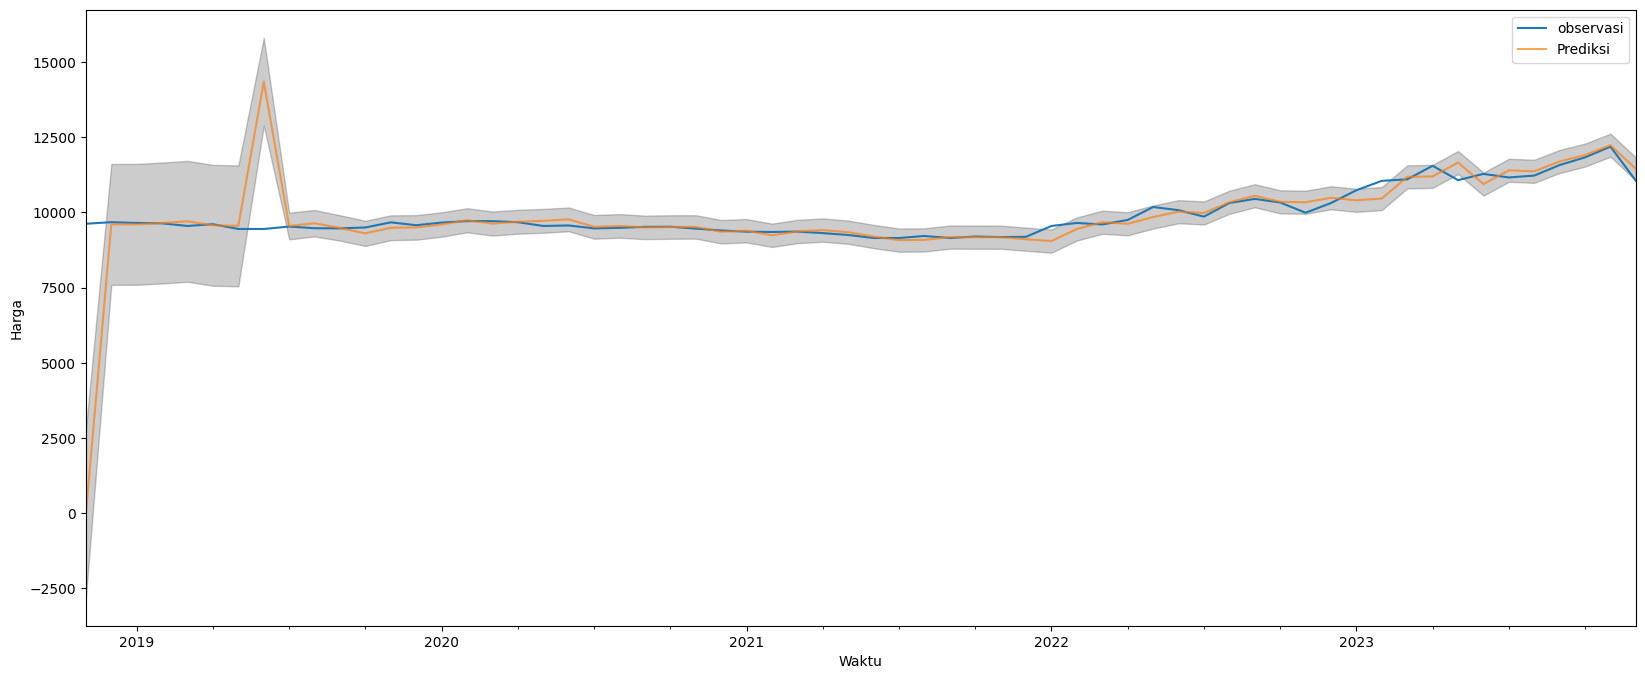

In [332]:
# Observasi VS Prediksi
ax = beras.plot(label="observasi", figsize=(20, 8))  # Plot data observasi

pred.predicted_mean.plot(ax=ax, label="Prediksi", alpha=0.7)  # Plot data prediksi

ax.fill_between(
    pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="k", alpha=0.2
)
ax.set_xlabel("Waktu")
ax.set_ylabel("Harga")
plt.legend()
plt.show()

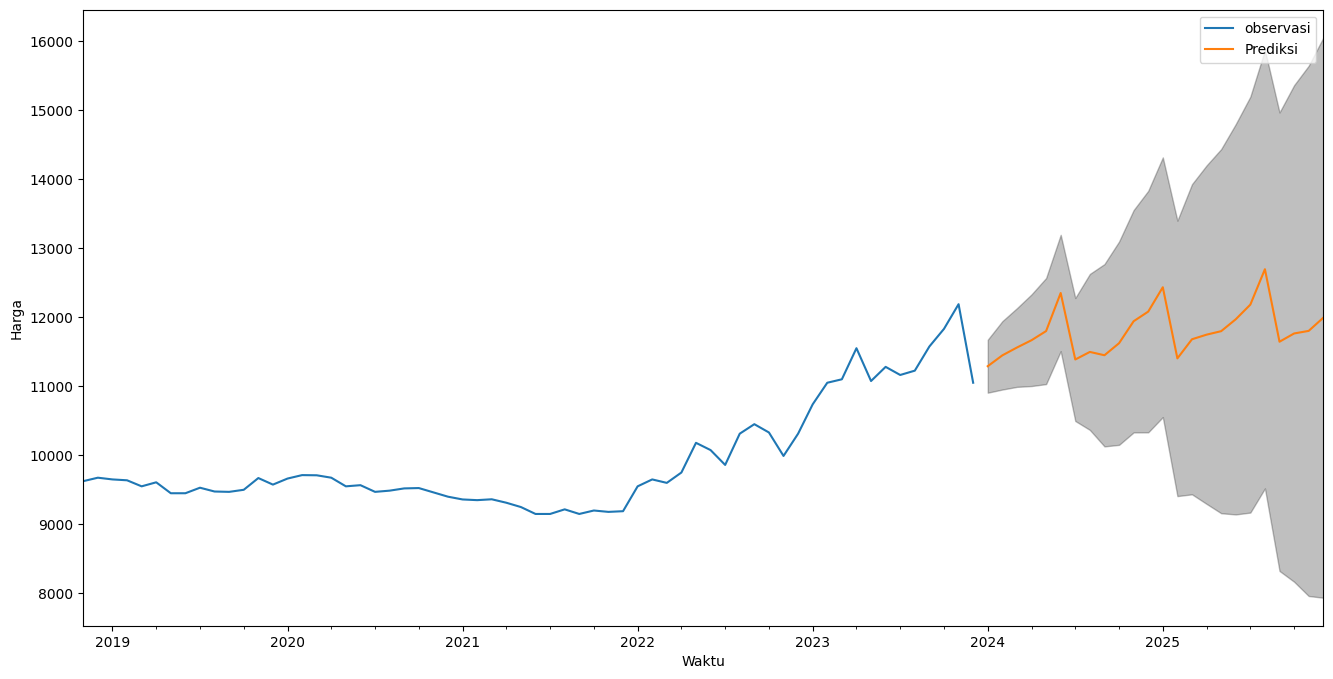

In [351]:
# Prediksi di masa depan
pred_uc = result.get_forecast(steps=24)  # Memprediksi data 24 bulan ke depan
pred_ci = pred_uc.conf_int()  # Menghitung interval kepercayaan
ax = beras.plot(label="observasi", figsize=(16, 8))  # Plot data observasi
pred_uc.predicted_mean.plot(ax=ax, label="Prediksi")  # Plot data prediksi
ax.fill_between(
    pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="k", alpha=0.25
)
ax.set_xlabel("Waktu")
ax.set_ylabel("Harga")
plt.legend()
plt.show()

# <center>**INPUT PREDIKSI KE CSV FILE**</center>


In [352]:
pred_ci.to_csv(r"predicted_RICE_price.csv")  # Menyimpan data prediksi ke file csv

In [242]:
pred_ci  # Menampilkan interval data prediksi di masa depan

,lower Beras,upper Beras
2024-01-01,10905.762589,11673.238971
2024-02-01,10951.584725,11941.312851
2024-03-01,10990.197494,12129.456032
2024-04-01,11002.173058,12329.199912
2024-05-01,11030.294523,12566.234573
2024-06-01,11507.224934,13191.701731
2024-07-01,10496.131875,12277.298205
2024-08-01,10366.658077,12625.657461
2024-09-01,10128.092808,12768.341406
2024-10-01,10150.444006,13094.114970


# <center>**PREDIKSI HARGA**</center>


In [355]:
# TO ACCESS PREDICTED PRICE GIVEN A DATE IN THE FUTURE
forecasted_data = (
    pred_uc.predicted_mean.to_frame()
)  # Membuat data frame dari data prediksi

forecasted_data_daily = forecasted_data.resample(
    "D"
).asfreq()  # Mengubah data prediksi menjadi data harian

forecasted_data_daily.interpolate(
    method="time", inplace=True
)  # Mengisi data kosong dengan interpolasi

tanggal_prediksi = str(
    input("Masukkan tanggal prediksi (YYYY-MM-DD): ")
)  # Memasukkan tanggal prediksi
harga_prediksi = forecasted_data_daily.loc[tanggal_prediksi]  # Menampilkan data prediksi pada tanggal 3 Februari 2024

print(harga_prediksi["predicted_mean"])  # Menampilkan data prediksi

KeyError: ''